## 1. WEB Scraping images

### 1.1 Function to scrap images from Google Images using Selenium

In [1]:
# The idea is based on example from: 
# https://medium.com/@nithishreddy0627/a-beginners-guide-to-image-scraping-with-python-and-selenium-38ec419be5ff

import requests as req
import os
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from PIL import Image
from io import BytesIO
import base64
import time

# Function use a key - string to search a specific images and get them using requests
# Here we could decide how many images will be downloaded by adjusting imagesQty variabel
# We use PIL library to work with images

def getAndStoreImages(key, initialMainPath, driver):
    link = f"https://www.google.com/search?q={key}&tbm=isch"
    imagesQty = 500
    initialFolderPath = os.path.join(initialMainPath, key)

    if not os.path.exists(initialFolderPath):
        os.makedirs(initialFolderPath)
    if len(os.listdir(initialFolderPath)) == 0:
            driver.get(link)
            for _ in range(imagesQty // 10):
                driver.execute_script("window.scrollBy(0,10000)")
                time.sleep(1)
            WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.CSS_SELECTOR, "img.Q4LuWd")))
            images = driver.find_elements(By.CSS_SELECTOR, "img.Q4LuWd")
            for index, image in enumerate(images[:imagesQty]):
                if index == 0:
                    continue
                try:
                    imageUrl = image.get_attribute("src")
                    if imageUrl.startswith("data:image"):
                        imageData = imageUrl.split(",")[1]
                        imageBin = base64.b64decode(imageData)
                        with open(os.path.join(initialFolderPath, f"{index}.jpg"), "wb") as f:
                            f.write(imageBin)
                    else:   
                        receivedImage = req.get(imageUrl)
                        receivedImage = Image.open(BytesIO(receivedImage.content))
                        receivedImage.save(os.path.join(initialFolderPath, f"{index}.jpg"))
                except Exception as ex:
                    print(f"Image {index} could not be downloaded", f"Reason -> {ex}")
                    continue

            

### 1.2 Specifying keywords for search
* Arundo donax -> https://artsdatabanken.no/lister/fremmedartslista/2023/5370
* Lantana camara -> https://en.wikipedia.org/wiki/List_of_invasive_species_in_Europe
* Pistia stratiotes -> https://www.invasivespeciesinfo.gov/aquatic/plants/water-lettuce
* Salvinia molesta -> https://www.invasivespeciesinfo.gov/aquatic/plants/giant-salvinia
* Acacia mearnsii -> https://en.wikipedia.org/wiki/List_of_invasive_species_in_Europe

In [2]:
invasivePlants = ["Arundo donax", "Lantana camara", "Pistia stratiotes", "Salvinia molesta", "Acacia mearnsii"]

### 1.3 Get images and store them into relative initial folders

In [3]:
# Information regarding installation and using of webdriver-manager from here: 
# https://stackoverflow.com/questions/40555930/selenium-chromedriver-executable-needs-to-be-in-path

# Information regarding swithcing off automatic control when opening page
# https://stackoverflow.com/questions/43143014/chrome-is-being-controlled-by-automated-test-software

# Solution for scraping images works in half-manual way
# When running this part, the chrome page will be automatically opens, and user has to accept cookies by clicking the Accept button
# And click on load more images button every time it appear.

from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
import os

currentWorkspacePath = os.getcwd()

initialFolderName = "initial"
initialMainPath = os.path.join(currentWorkspacePath, initialFolderName)

if not os.path.exists(initialMainPath):
    os.makedirs(initialMainPath)
    if len(os.listdir(initialMainPath)) == 0:
        driverPath = ChromeDriverManager().install()
        options = webdriver.ChromeOptions()
        options.add_experimental_option("excludeSwitches", ['enable-automation'])
        driver = webdriver.Chrome(options=options)
        try:
            for plant in invasivePlants:
                getAndStoreImages(plant, initialMainPath, driver)

        finally:
            driver.quit()
            
        print("[OK] Initial images are stored in folder")

else:
    print("[OK] All initial images already in the folder")



[OK] All initial images already in the folder


### 1.4 Download, unzip and store Dataset

In this project the following dataset has been used:  
https://www.kaggle.com/datasets/dsidharth/invasive-species-in-kerala-india

In [4]:
# Information regarding downloading dataset directly from kaggle is here:
# https://medium.com/@ankushchoubey/how-to-download-dataset-from-kaggle-7f700d7f9198
# https://medium.com/mcd-unison/using-the-kaggle-api-e43e902fba23

# !!! IMPORTANT
# Before running this code you need to go to Kaggle.com -> log in -> go to Settings -> under API in settings click on Create New Token
# This will download a kaggle.json file that will be used further in this code
# Move this downloaded json file from Downloads to working directory where this notebook and other project folders are -> here -> currentWorkspacePath

import kaggle
import os
import shutil
import subprocess
import glob
import zipfile as z
from PIL import Image

# !!! Change to False if you want to keep folder with dataset archive
removeArchiveFlag = False

currentWorkspacePath = os.getcwd()

initDatasetPath = os.path.join(os.path.expanduser('~'), '.kaggle')
fileName = 'kaggle.json'
file = os.path.join(currentWorkspacePath, fileName)
uploadPath = os.path.join(currentWorkspacePath, 'archive')
pathToDataset = os.path.join(uploadPath, "Dataset")
executionCommand = f'kaggle datasets download -d dsidharth/invasive-species-in-kerala-india -p "{uploadPath}"'
executionCommand = executionCommand.replace("\\", "/")

# Working with .kaggle.json file
if not os.path.exists(initDatasetPath):
    os.makedirs(initDatasetPath)
    shutil.copy(file, initDatasetPath)
    os.chmod(os.path.join(initDatasetPath, fileName), 0o600)
    print("[OK] Kaggle file is copied to the destination")

# Downloading the .zip file
if not os.path.exists(uploadPath):
    subprocess.call(executionCommand, shell=True)
    print("[OK] Downloading of zip archive is started")

# Search for zip file in a folder and extract
if len(os.listdir(uploadPath)) == 1:
    zipFileInstance = glob.glob(os.path.join(uploadPath, '*.zip'))
    with z.ZipFile(zipFileInstance[0], 'r') as zipF:
        zipF.extractall(uploadPath)
    print("[OK] All files extracted")

# Store images in initial folders as jpg
if os.path.exists(initialMainPath) and len(os.listdir(initialMainPath)) > 1:
    for plant in invasivePlants:
        if len(os.listdir(os.path.join(initialMainPath, plant))) < 500:
            path = os.path.join(pathToDataset, plant)
            images = os.listdir(path)
            for image in images:
                fromImage = Image.open(os.path.join(path,image))
                fromImage = fromImage.convert("RGB")
                toPath = os.path.join(initialMainPath, plant)
                fromImage.save(os.path.join(toPath, f"{image}.jpg"))
    print("[OK] Images are placed into working directories")

# Remove folder with Dataset images and archive file
if removeArchiveFlag is True:
    if os.path.exists(uploadPath):
        shutil.rmtree(uploadPath)
        print("[OK] Folder containing dataset archive is deleted")
    else:
        print("[OK] Folder containing dataset not found. Deleted before...")


[OK] Images are placed into working directories


## 2. Working with images

### 2.1 Function that adjusts initial images' size to 180 x 180 pixels  
Due to significant variance in image sizes, the initial size to all images is set to 180 x 180


#### Following Position augmentation techniques are used here:
* Center Crop
* Add Borders - extend to 180 px

In [5]:
from PIL import Image

# Function that crop images when width or height > 180 px
def cropImage(image, targetImageSize):
    width, height = image.size

    if width > targetImageSize[0]:
        left = (width - targetImageSize[0]) // 2
        right = left + targetImageSize[0]
    else:
        left = 0
        right = width
    if height > targetImageSize[1]:
        top = (height - targetImageSize[1]) // 2
        bottom = top + targetImageSize[1]
    else:
        bottom = height
        top = 0
    croppedImage = image.crop((left, top, right, bottom))
    return croppedImage

# Function that add white border when width or height < 180 px
def extendImage(image : Image, targetImageSize, borderColor) -> Image:
    width, height = image.size

    extendWidth = max(0, (targetImageSize[0] - width) // 2)
    extendHeight = max(0, (targetImageSize[1] - height) // 2)
    extendedImage = Image.new("RGB", targetImageSize, borderColor)
    extendedImage.paste(image, (extendWidth, extendHeight))
    return extendedImage

# The main function itself
def adjustAndStoreImages(initPath, newPath, targetImageSize, borderColor):
    for imageName in os.listdir(initPath):
        imagePath = os.path.join(initPath, imageName)
        image = Image.open(imagePath)

        if image.size[0] > targetImageSize[0] or image.size[1] > targetImageSize[1]:
            image = cropImage(image, targetImageSize)
        if image.size[0] < targetImageSize[0] or image.size[1] < targetImageSize[1]:
            image = extendImage(image, targetImageSize, borderColor)
            
        pathToFile = os.path.join(newPath, imageName)
        image.save(pathToFile)

### 2.2 Adjust and store images in 180 x 180 format

In [6]:
# Target size is set to 180 x 180
targetImageSize = (180, 180)
borderColor = (255, 255, 255)
pathToInitial = os.path.join(currentWorkspacePath, "initial")
listOfInitialSubFolders = os.listdir(pathToInitial)
pathToAdjusted = os.path.join(currentWorkspacePath, "adjusted")

if not os.path.exists(pathToAdjusted):
    os.makedirs(pathToAdjusted)
    for folderName in listOfInitialSubFolders:
        pathToInitialSubFolder = os.path.join(pathToInitial, folderName)
        pathToAdjustedSubfolder = os.path.join(pathToAdjusted, folderName)

        if not os.path.exists(pathToAdjustedSubfolder):
            os.makedirs(pathToAdjustedSubfolder)
        if len(os.listdir(pathToAdjustedSubfolder)) == 0:
            adjustAndStoreImages(pathToInitialSubFolder, pathToAdjustedSubfolder, targetImageSize, borderColor)
    print("[OK] Modified images are stored in folder")
else:
    print("[OK] Modified images are already stored in folder")
    
    

[OK] Modified images are already stored in folder


### 2.3 Preparing training and testing sets

In [7]:
# We use 80% of images for training and 20% for testing
trainPercent = 80
pathToReady = os.path.join(currentWorkspacePath, "ready")
pathToTrain = os.path.join(pathToReady, "train")
pathToTest = os.path.join(pathToReady, "test")

# Function to open and store image
def openAndSaveImage(pathFrom, pathTo, fileName):
    image = Image.open(os.path.join(pathFrom, fileName))
    image.save(os.path.join(pathTo, fileName))

# Main code block
if not os.path.exists(pathToReady):
    os.makedirs(pathToReady)
if len(os.listdir(pathToReady)) == 0:
    os.makedirs(pathToTrain)
    os.makedirs(pathToTest)
     
classes = [dir for dir in os.listdir(pathToAdjusted)]

if len(os.listdir(pathToTrain)) == 0 and len(os.listdir(pathToTest)) == 0:
    for cl in classes:  
        pathToTrainSubfolder = os.path.join(pathToTrain, cl)
        pathToTestSubfolder = os.path.join(pathToTest, cl)
        os.makedirs(pathToTrainSubfolder)
        os.makedirs(pathToTestSubfolder)
        pathToAdjustedSubfolder = os.path.join(pathToAdjusted, cl)

        qtyFilesInAdjustedSubfolder = len(os.listdir(pathToAdjustedSubfolder))
        number = (qtyFilesInAdjustedSubfolder * trainPercent) // 100

        for file in os.listdir(pathToAdjustedSubfolder)[:number]:
            openAndSaveImage(pathToAdjustedSubfolder, pathToTrainSubfolder, file)
        for file in os.listdir(pathToAdjustedSubfolder)[number:]:
            openAndSaveImage(pathToAdjustedSubfolder, pathToTestSubfolder, file)

    print("[OK] Train and test sets with images are ready")

else:
    print("[OK] All train and test sets with images already here")

[OK] All train and test sets with images already here


### 2.4 Applying data augmentation using Image Data Generator
#### Here we will use both Position and Color Augmentation.
#### The following generators will be used:
* TrainGeneratorPosition -> rotation, shear, width_shift, horizontal_flip, vertical_flip, height_shift, zoom
* TrainGeneratorColor -> rotation, shear, width_shift, horizontal_flip, vertical_flip, height_shift, zoom, brightness, channel_shift


Found 5118 images belonging to 5 classes.
Found 5118 images belonging to 5 classes.
Found 1282 images belonging to 5 classes.

Following classes are available: Acacia mearnsii, Arundo donax, Lantana camara, Pistia stratiotes, Salvinia molesta

******** TRAIN SET - POSITION *********
images count = 32
targets count = 32
***************************************

******** TRAIN SET - COLOR *********
images count = 32
targets count = 32
***************************************



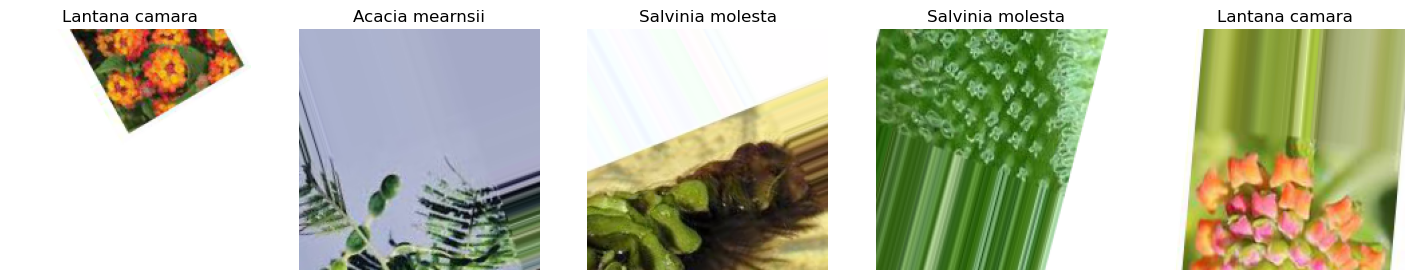

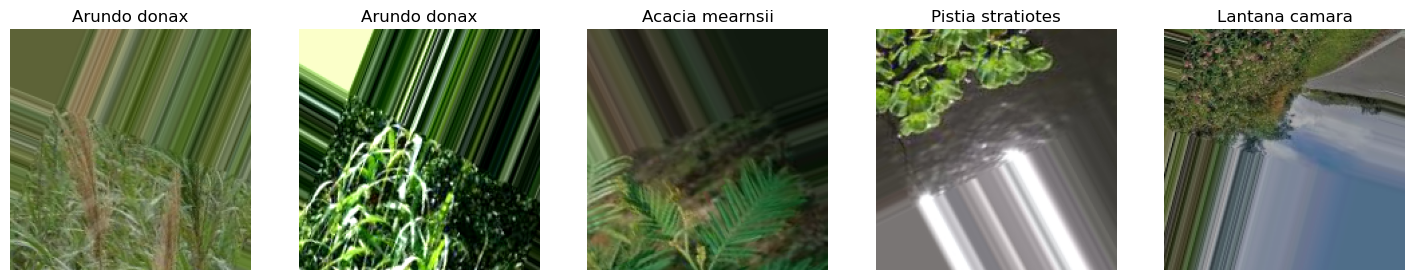

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


# Set up batch size
batchSize = 32

# Seed
seed = 42

# Image Generator based on Position augmentation
trainImageGenerator_position = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=30,
    shear_range=0.2,
    width_shift_range=[-80,80],
    horizontal_flip=True,
    vertical_flip=True,
    height_shift_range=0.1,
    zoom_range=0.2,
    fill_mode='nearest')

# Image Generator based on Color augmentation
trainImageGenerator_color = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=30,
    shear_range=0.2,
    width_shift_range=[-80,80],
    horizontal_flip=True,
    vertical_flip=True,
    height_shift_range=0.1,
    zoom_range=0.2,
    brightness_range=[0.5, 1.5],
    channel_shift_range=20)

# Image Generator for test set
testImageGenerator = ImageDataGenerator(rescale=1/255.)

# Creating a generator for position train set
trainGen_position = trainImageGenerator_position.flow_from_directory(
    pathToTrain, 
    target_size=targetImageSize,
    batch_size=batchSize,
    shuffle=True,
    class_mode='sparse'
    #seed=seed
    )

print(trainGen_position)

# Creating a generator for color train set
trainGen_color = trainImageGenerator_color.flow_from_directory(
    pathToTrain, 
    target_size=targetImageSize,
    batch_size=batchSize,
    shuffle=True,
    class_mode='sparse'
    #seed=seed
    )

print(trainGen_color)

# Creating a generator for test set
testGen = testImageGenerator.flow_from_directory(
    pathToTest, 
    target_size=targetImageSize,
    batch_size=batchSize,
    shuffle=False,
    class_mode='sparse'
    #seed=seed
    )

samplesPosition = trainGen_position.next()
imageByPosition = samplesPosition[0]
targetByPosition = samplesPosition[1]


samplesColor = trainGen_color.next()
imageByColor = samplesColor[0]
targetByColor = samplesColor[1]

# Print out input data for models
print(f"\nFollowing classes are available: {', '.join(classes)}\n")

print("******** TRAIN SET - POSITION *********")
print(f"images count = {len(imageByPosition)}")
print(f"targets count = {len(targetByPosition)}")
print("***************************************\n")

print("******** TRAIN SET - COLOR *********")
print(f"images count = {len(imageByColor)}")
print(f"targets count = {len(targetByColor)}")
print("***************************************\n")

# Print some images from train set position
plt.figure(figsize = (18,18))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.subplots_adjust(hspace=0.2,wspace=0.2)
    plt.imshow(imageByPosition[i])
    plt.title(f"{classes[int(targetByPosition[i])]}")
    plt.axis('off')

# Print some images from train set color
plt.figure(figsize = (18,18))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.subplots_adjust(hspace=0.2,wspace=0.2)
    plt.imshow(imageByColor[i])
    plt.title(f"{classes[int(targetByColor[i])]}")
    plt.axis('off')  

### 2.5 Prepare images and targets for grid search

In [9]:
import numpy as np
import math

# Because of very high amount of computational work and memory problems in grid search
# Just 5% of generating images/batches will be used
nrOfBatchesInPercents = 5

all_ImagesPosition = []
all_TargetsPosition = []
all_ImagesColor = []
all_TargetsColor = []

# Total qty of batches
qtyBatches_position = int(len(trainGen_position.filenames) * nrOfBatchesInPercents / 100) // batchSize
qtyBatches_color = int(len(trainGen_color.filenames) * nrOfBatchesInPercents / 100) // batchSize

# Choose batches randomly
randomBatch_position = np.random.choice(len(trainGen_position), qtyBatches_position, replace=False)
randomBatch_color = np.random.choice(len(trainGen_color), qtyBatches_color, replace=False)

# Create total -> images and targets for Position
for batchIndex in randomBatch_position:
    samplesPosition = trainGen_position[batchIndex]
    all_ImagesPosition.append(samplesPosition[0])
    all_TargetsPosition.append(samplesPosition[1])

# Create total -> images and targets for Color
for batchIndex in randomBatch_color:
    samplesColor = trainGen_color[batchIndex]
    all_ImagesColor.append(samplesColor[0])
    all_TargetsColor.append(samplesColor[1])

# Connect instances
imagesByPosition = np.concatenate(all_ImagesPosition)
targetsByPosition = np.concatenate(all_TargetsPosition)
imagesByColor = np.concatenate(all_ImagesColor)
targetsByColor = np.concatenate(all_TargetsColor)

print(f"Shape of imagesByPosition: {imagesByPosition.shape}\n"
      f"Shape of targetsByPosition: {targetsByColor.shape}\n"
      f"Shape of imagesByColor: {imagesByColor.shape}\n"
      f"Shape of targetsByCOlor: {targetsByColor.shape}")
print()
print(f"Size of imagesByPosition: {len(imagesByPosition)}\n"
      f"Size of targetsByPosition: {len(targetsByColor)}\n"
      f"Size of imagesByColor: {len(imagesByColor)}\n"
      f"Size of targetsByCOlor: {len(targetsByColor)}")

Shape of imagesByPosition: (224, 180, 180, 3)
Shape of targetsByPosition: (224,)
Shape of imagesByColor: (224, 180, 180, 3)
Shape of targetsByCOlor: (224,)

Size of imagesByPosition: 224
Size of targetsByPosition: 224
Size of imagesByColor: 224
Size of targetsByCOlor: 224


## 3. Working with models

Ideas regarding establishing and fine-tuning the model is based on example from here:  
https://pyimagesearch.com/2020/04/27/fine-tuning-resnet-with-keras-tensorflow-and-deep-learning/

More information regarding ResNet50 model config parameters are given here:  
https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50

### 3.1 Working with ResNet50 models

#### 3.1.1 Model NO-1 spesific parameters:
- Activation function in first top layer = "relu"
- Optimizer = Adam
- Augmented train data set - Position

In [10]:
from tensorflow.keras.optimizers import Adam, Adagrad

activ_1 = "relu"
optimizer_1 = Adam()

#### 3.1.2 Model NO-2 spesific parameters:
- Activation function in first top layer = "relu"
- Optimizer = Adam
- Augmented train data set - Color

In [11]:
activ_2 = "relu"
optimizer_2 = Adam()

#### 3.1.3 Model NO-3 spesific parameters:
- Activation function in first top layer = "sigmoid"
- Optimizer = Adagrad
- Augmented train data set - Position

In [12]:
activ_3 = "sigmoid"
optimizer_3 = Adagrad()

#### 3.1.4 Model NO-4 spesific parameters:
- Activation function in first top layer = "sigmoid"
- Optimizer = Adagrad
- Augmented train data set - Color

In [13]:
activ_4 = "sigmoid"
optimizer_4 = Adagrad()

#### 3.1.5 ResNet50 Models' setup and feature extraction + fine tuning

In [14]:
# Make function for establishing models
# Idea about feature extraction and fine tuning with ResNet50 based on this example: 
# https://medium.com/@kenneth.ca95/a-guide-to-transfer-learning-with-keras-using-resnet50-a81a4a28084b

from tensorflow.keras.layers import Dropout, Dense, Flatten, Input
from tensorflow.keras.optimizers import Adam, Adagrad
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential

def makeResNet50Model(activation="relu", optimizer=Adam(), learning_rate=0.1, dropout_rate=0.0, dense_units=512):

    inputTens=Input(shape=(targetImageSize[0], targetImageSize[1], 3))
    resNet50 = ResNet50(weights="imagenet", include_top=False, input_tensor=inputTens)

    # We freeze all layers until 42-th layer
    # I have tested different layers and it took many hours to determine this layer
    # Layer 42 has been chosen
    for layer in resNet50.layers[:42]:
        layer.trainable = False

    model = Sequential()
    model.add(resNet50)
    model.add(Flatten(name="flatten"))
    model.add(Dense(dense_units, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(len(classes), activation="softmax"))

    optimizer = optimizer.__class__(learning_rate=learning_rate)

    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])

    return model

# Just checking that modifications are applied
modResNet50 = makeResNet50Model()
print(f"Amount of layers in base ResNet50 model -> {len(modResNet50.layers[0].layers)}")
for index, layer in enumerate(modResNet50.layers[0].layers):
    print(f"Layer {index+1}: {layer.name} -> {layer.trainable}")

print()

# Print the layers added on top of the base model
print(f"Amount of layers at the top of ResNet50 model -> {len(modResNet50.layers)}")
for index, layer in enumerate(modResNet50.layers):
    print(f"Layer {index+1}: {layer.name} -> {layer.trainable}")




Amount of layers in base ResNet50 model -> 175
Layer 1: input_1 -> False
Layer 2: conv1_pad -> False
Layer 3: conv1_conv -> False
Layer 4: conv1_bn -> False
Layer 5: conv1_relu -> False
Layer 6: pool1_pad -> False
Layer 7: pool1_pool -> False
Layer 8: conv2_block1_1_conv -> False
Layer 9: conv2_block1_1_bn -> False
Layer 10: conv2_block1_1_relu -> False
Layer 11: conv2_block1_2_conv -> False
Layer 12: conv2_block1_2_bn -> False
Layer 13: conv2_block1_2_relu -> False
Layer 14: conv2_block1_0_conv -> False
Layer 15: conv2_block1_3_conv -> False
Layer 16: conv2_block1_0_bn -> False
Layer 17: conv2_block1_3_bn -> False
Layer 18: conv2_block1_add -> False
Layer 19: conv2_block1_out -> False
Layer 20: conv2_block2_1_conv -> False
Layer 21: conv2_block2_1_bn -> False
Layer 22: conv2_block2_1_relu -> False
Layer 23: conv2_block2_2_conv -> False
Layer 24: conv2_block2_2_bn -> False
Layer 25: conv2_block2_2_relu -> False
Layer 26: conv2_block2_3_conv -> False
Layer 27: conv2_block2_3_bn -> Fal

### 3.2 Working with experimental EfficientNetB0 models

#### 3.2.1 Model NO-5 spesific parameters:
- Activation function in first top layer = "relu"
- Optimizer = Adam
- Augmented train data set - Position

In [15]:
activ_5 = "relu"
optimizer_5 = Adam()

#### 3.2.2 Model NO-6 spesific parameters:
- Activation function in first top layer = "relu"
- Optimizer = Adam
- Augmented train data set - Color

In [16]:
activ_6 = "relu"
optimizer_6 = Adam()

#### 3.2.3 Model NO-7 spesific parameters:
- Activation function in first top layer = "sigmoid"
- Optimizer = Adagrad
- Augmented train data set - Position

In [17]:
activ_7 = "sigmoid"
optimizer_7 = Adagrad()

#### 3.2.4 Model NO-8 spesific parameters:
- Activation function in first top layer = "sigmoid"
- Optimizer = Adagrad
- Augmented train data set - Color

In [18]:
activ_8 = "sigmoid"
optimizer_8 = Adagrad()

#### 3.2.5 EfficientNet Models' setup and feature extraction + fine tuning

In [19]:
# Make function for establishing models
# Idea about feature extraction and fine tuning with EfficientNetB0 based on this example: 
# https://www.dlology.com/blog/transfer-learning-with-efficientnet

from tensorflow.keras.layers import Dropout, Dense, Flatten, Input
from tensorflow.keras.optimizers import Adam, Adagrad
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential

def makeEffNetB0Model(activation="relu", optimizer=Adam(), learning_rate=0.1, dropout_rate=0.0, dense_units=512):

    inputTens=Input(shape=(targetImageSize[0], targetImageSize[1], 3))
    effNet = EfficientNetB0(weights="imagenet", include_top=False, input_tensor=inputTens)

    # We freeze all layers until 43-th layer
    # I have tested different layers and it took many hours to determine this layer number.
    # Layer 43 has been chosen
    for layer in effNet.layers[:43]:
        layer.trainable = False
    
    # Need to freeze last three output layers
    topConvLayerIndex = None
    for index, layer in enumerate(effNet.layers):
        if layer.name == "top_conv":
            topConvLayerIndex = index
            break
    if topConvLayerIndex is not None:
        for layer in effNet.layers[topConvLayerIndex:]:  
            layer.trainable = False

    model = Sequential()
    model.add(effNet)
    model.add(Flatten(name="flatten"))
    model.add(Dense(dense_units, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(len(classes), activation="softmax"))

    optimizer = optimizer.__class__(learning_rate=learning_rate)

    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])

    return model

# Just checking that modifications are applied
modEffNetB0 = makeEffNetB0Model()
print(f"Amount of layers in base EfficientNetB0 model -> {len(modEffNetB0.layers[0].layers)}")
for index, layer in enumerate(modEffNetB0.layers[0].layers):
    print(f"Layer {index+1}: {layer.name} -> {layer.trainable}")

print()

# Print the layers added on top of the base model
print(f"Amount of layers at the top of EfficientNetB0 model -> {len(modEffNetB0.layers)}")
for index, layer in enumerate(modEffNetB0.layers):
    print(f"Layer {index+1}: {layer.name} -> {layer.trainable}")

Amount of layers in base EfficientNetB0 model -> 238
Layer 1: input_2 -> False
Layer 2: rescaling -> False
Layer 3: normalization -> False
Layer 4: rescaling_1 -> False
Layer 5: stem_conv_pad -> False
Layer 6: stem_conv -> False
Layer 7: stem_bn -> False
Layer 8: stem_activation -> False
Layer 9: block1a_dwconv -> False
Layer 10: block1a_bn -> False
Layer 11: block1a_activation -> False
Layer 12: block1a_se_squeeze -> False
Layer 13: block1a_se_reshape -> False
Layer 14: block1a_se_reduce -> False
Layer 15: block1a_se_expand -> False
Layer 16: block1a_se_excite -> False
Layer 17: block1a_project_conv -> False
Layer 18: block1a_project_bn -> False
Layer 19: block2a_expand_conv -> False
Layer 20: block2a_expand_bn -> False
Layer 21: block2a_expand_activation -> False
Layer 22: block2a_dwconv_pad -> False
Layer 23: block2a_dwconv -> False
Layer 24: block2a_bn -> False
Layer 25: block2a_activation -> False
Layer 26: block2a_se_squeeze -> False
Layer 27: block2a_se_reshape -> False
Layer 28

## 4. Hyperparameter tuning using Grid Search 

Hyperparameter tuning is based on example from here:  
https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
and  
https://inria.github.io/scikit-learn-mooc/python_scripts/parameter_tuning_randomized_search.html

#### Search is performed for: 
* Learning rate
* Dropout rate
* Dense units

In [20]:
import builtins
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.backend import clear_session
import os

# Lower result of search grid is not so important at this point ->
# -> Main idea is comparing of three parameters and give us the best combination of those.
# Compared parameters are: drop rate, learning rate and numbers of units in dense layer

# Clear memory before running grid search -> not sure if this necessary but just in case
clear_session()

# Set available cores as max_cors * 0.3 (My PC has 12 cores -> just 4 cores will be used)
# This is due to memory problems.
MAX_CORS = os.cpu_count()
corsQty = round(MAX_CORS * 0.3)
print(corsQty)

# Store current logging
currentLogging = tf.get_logger().getEffectiveLevel()

# Disable logging except Error level during grid search -> else it will produce a lot of output data
tf.get_logger().setLevel(tf.compat.v1.logging.ERROR)

def setupAndRunGridSearch(modelIdent, images, targets, corsQty, optimizer, activation):
    params = {
        'optimizer':[optimizer],
        'optimizer__learning_rate':[0.0001, 0.001],
        'model__dropout_rate': [0.1, 0.3, 0.5],
        'model__dense_units': [256, 512],
        'model__activation': [activation],
        'batch_size': [32]
    }

    # ResNet50 models
    if modelIdent <= 4:
        model = KerasClassifier(model=makeResNet50Model, verbose=0)

    # EfficientNetB0 models
    elif modelIdent > 4:
        model = KerasClassifier(model=makeEffNetB0Model, verbose=0)

    # StratifiedKFold has been used because amount of images in every class varied between 800 and 1200
    grid = GridSearchCV(estimator=model, param_grid=params, scoring="accuracy", cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42), n_jobs=corsQty)
    result = grid.fit(images, targets)
    print(f"Model NO-{modelIdent}")
    print(f"Best: {result.best_score_} using {result.best_params_}")
    means = result.cv_results_['mean_test_score']
    stds = result.cv_results_['std_test_score']
    params = result.cv_results_['params']
    for mean, stdev, param in builtins.zip(means, stds, params):
        print(f"{mean} ({stdev}) with: {param}")
    clear_session()
    return (f"Calling: {model.model.__name__} Model NO-{modelIdent} Best: {result.best_score_} using {result.best_params_}", result.best_params_)

# List of results
resultList = []

# List of optimizers
optimizerList = [optimizer_1, optimizer_2, optimizer_3, optimizer_4, optimizer_5, optimizer_6, optimizer_7, optimizer_8]

# List of acivation functions
activationList = [activ_1, activ_2, activ_3, activ_4, activ_5, activ_6, activ_7, activ_8]

# Running Grid Search
for ident in range(1,9):
#for ident in range(2,3): ### DELEETE
    if ident % 2 == 1:
        result = setupAndRunGridSearch(
            ident, 
            imagesByPosition, 
            targetsByPosition, 
            corsQty, 
            optimizerList[ident-1].get_config()['name'], 
            activationList[ident-1])
    elif ident % 2 == 0:
        result = setupAndRunGridSearch(
            ident, 
            imagesByColor, 
            targetsByColor, 
            corsQty, 
            optimizerList[ident-1].get_config()['name'], 
            activationList[ident-1])
    resultList.append(result)

# Get back initial logging after grid search
tf.get_logger().setLevel(currentLogging)

# print results
for line in resultList:
    print(line[0])

4



c:\Users\oddva\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Model NO-1
Best: 0.2146546546546547 using {'batch_size': 32, 'model__activation': 'relu', 'model__dense_units': 512, 'model__dropout_rate': 0.3, 'optimizer': 'Adam', 'optimizer__learning_rate': 0.0001}
0.17411411411411412 (0.0011041907694204363) with: {'batch_size': 32, 'model__activation': 'relu', 'model__dense_units': 256, 'model__dropout_rate': 0.1, 'optimizer': 'Adam', 'optimizer__learning_rate': 0.0001}
0.17411411411411412 (0.0011041907694204363) with: {'batch_size': 32, 'model__activation': 'relu', 'model__dense_units': 256, 'model__dropout_rate': 0.1, 'optimizer': 'Adam', 'optimizer__learning_rate': 0.001}
0.17411411411411412 (0.0011041907694204363) with: {'batch_size': 32, 'model__activation': 'relu', 'model__dense_units': 256, 'model__dropout_rate': 0.3, 'optimizer': 'Adam', 'optimizer__learning_rate': 0.0001}
0.16966966966966968 (0.006904033871710058) with: {'batch_size': 32, 'model__activation': 'relu', 'model__dense_units': 256, 'model__dropout_rate': 0.3, 'optimizer': 'Ada

c:\Users\oddva\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Model NO-2
Best: 0.20528528528528525 using {'batch_size': 32, 'model__activation': 'relu', 'model__dense_units': 256, 'model__dropout_rate': 0.1, 'optimizer': 'Adam', 'optimizer__learning_rate': 0.0001}
0.20528528528528525 (0.015749942008969373) with: {'batch_size': 32, 'model__activation': 'relu', 'model__dense_units': 256, 'model__dropout_rate': 0.1, 'optimizer': 'Adam', 'optimizer__learning_rate': 0.0001}
0.17861861861861864 (0.007474522131461406) with: {'batch_size': 32, 'model__activation': 'relu', 'model__dense_units': 256, 'model__dropout_rate': 0.1, 'optimizer': 'Adam', 'optimizer__learning_rate': 0.001}
0.1965165165165165 (0.01767929870350328) with: {'batch_size': 32, 'model__activation': 'relu', 'model__dense_units': 256, 'model__dropout_rate': 0.3, 'optimizer': 'Adam', 'optimizer__learning_rate': 0.0001}
0.1963963963963964 (0.01202041747953574) with: {'batch_size': 32, 'model__activation': 'relu', 'model__dense_units': 256, 'model__dropout_rate': 0.3, 'optimizer': 'Adam', 'o

c:\Users\oddva\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Model NO-3
Best: 0.26354354354354353 using {'batch_size': 32, 'model__activation': 'sigmoid', 'model__dense_units': 512, 'model__dropout_rate': 0.3, 'optimizer': 'Adagrad', 'optimizer__learning_rate': 0.0001}
0.18306306306306305 (0.006956604077150877) with: {'batch_size': 32, 'model__activation': 'sigmoid', 'model__dense_units': 256, 'model__dropout_rate': 0.1, 'optimizer': 'Adagrad', 'optimizer__learning_rate': 0.0001}
0.21909909909909908 (0.055561756004935396) with: {'batch_size': 32, 'model__activation': 'sigmoid', 'model__dense_units': 256, 'model__dropout_rate': 0.1, 'optimizer': 'Adagrad', 'optimizer__learning_rate': 0.001}
0.20966966966966968 (0.0497402463818601) with: {'batch_size': 32, 'model__activation': 'sigmoid', 'model__dense_units': 256, 'model__dropout_rate': 0.3, 'optimizer': 'Adagrad', 'optimizer__learning_rate': 0.0001}
0.21909909909909908 (0.055561756004935396) with: {'batch_size': 32, 'model__activation': 'sigmoid', 'model__dense_units': 256, 'model__dropout_rate':

c:\Users\oddva\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Model NO-4
Best: 0.21429429429429434 using {'batch_size': 32, 'model__activation': 'sigmoid', 'model__dense_units': 512, 'model__dropout_rate': 0.3, 'optimizer': 'Adagrad', 'optimizer__learning_rate': 0.0001}
0.1965165165165165 (0.01767929870350328) with: {'batch_size': 32, 'model__activation': 'sigmoid', 'model__dense_units': 256, 'model__dropout_rate': 0.1, 'optimizer': 'Adagrad', 'optimizer__learning_rate': 0.0001}
0.20084084084084086 (0.009874721400391404) with: {'batch_size': 32, 'model__activation': 'sigmoid', 'model__dense_units': 256, 'model__dropout_rate': 0.1, 'optimizer': 'Adagrad', 'optimizer__learning_rate': 0.001}
0.20984984984984986 (0.007063635040475271) with: {'batch_size': 32, 'model__activation': 'sigmoid', 'model__dense_units': 256, 'model__dropout_rate': 0.3, 'optimizer': 'Adagrad', 'optimizer__learning_rate': 0.0001}
0.20096096096096097 (0.012082675038298688) with: {'batch_size': 32, 'model__activation': 'sigmoid', 'model__dense_units': 256, 'model__dropout_rate':

c:\Users\oddva\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Model NO-5
Best: 0.2590990990990991 using {'batch_size': 32, 'model__activation': 'relu', 'model__dense_units': 512, 'model__dropout_rate': 0.3, 'optimizer': 'Adam', 'optimizer__learning_rate': 0.0001}
0.21021021021021022 (0.06181998057494499) with: {'batch_size': 32, 'model__activation': 'relu', 'model__dense_units': 256, 'model__dropout_rate': 0.1, 'optimizer': 'Adam', 'optimizer__learning_rate': 0.0001}
0.21909909909909908 (0.055561756004935396) with: {'batch_size': 32, 'model__activation': 'relu', 'model__dense_units': 256, 'model__dropout_rate': 0.1, 'optimizer': 'Adam', 'optimizer__learning_rate': 0.001}
0.17855855855855854 (0.00581249830002893) with: {'batch_size': 32, 'model__activation': 'relu', 'model__dense_units': 256, 'model__dropout_rate': 0.3, 'optimizer': 'Adam', 'optimizer__learning_rate': 0.0001}
0.17417417417417416 (0.011931260100265725) with: {'batch_size': 32, 'model__activation': 'relu', 'model__dense_units': 256, 'model__dropout_rate': 0.3, 'optimizer': 'Adam', '

c:\Users\oddva\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Model NO-6
Best: 0.21873873873873872 using {'batch_size': 32, 'model__activation': 'relu', 'model__dense_units': 512, 'model__dropout_rate': 0.1, 'optimizer': 'Adam', 'optimizer__learning_rate': 0.0001}
0.20540540540540542 (0.013302455927838684) with: {'batch_size': 32, 'model__activation': 'relu', 'model__dense_units': 256, 'model__dropout_rate': 0.1, 'optimizer': 'Adam', 'optimizer__learning_rate': 0.0001}
0.191951951951952 (0.005783256753014162) with: {'batch_size': 32, 'model__activation': 'relu', 'model__dense_units': 256, 'model__dropout_rate': 0.1, 'optimizer': 'Adam', 'optimizer__learning_rate': 0.001}
0.20984984984984986 (0.007063635040475271) with: {'batch_size': 32, 'model__activation': 'relu', 'model__dense_units': 256, 'model__dropout_rate': 0.3, 'optimizer': 'Adam', 'optimizer__learning_rate': 0.0001}
0.20096096096096097 (0.019571103012302686) with: {'batch_size': 32, 'model__activation': 'relu', 'model__dense_units': 256, 'model__dropout_rate': 0.3, 'optimizer': 'Adam', 

c:\Users\oddva\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Model NO-7
Best: 0.22750750750750748 using {'batch_size': 32, 'model__activation': 'sigmoid', 'model__dense_units': 256, 'model__dropout_rate': 0.1, 'optimizer': 'Adagrad', 'optimizer__learning_rate': 0.0001}
0.22750750750750748 (0.055983450763345974) with: {'batch_size': 32, 'model__activation': 'sigmoid', 'model__dense_units': 256, 'model__dropout_rate': 0.1, 'optimizer': 'Adagrad', 'optimizer__learning_rate': 0.0001}
0.16954954954954957 (0.01574971297720278) with: {'batch_size': 32, 'model__activation': 'sigmoid', 'model__dense_units': 256, 'model__dropout_rate': 0.1, 'optimizer': 'Adagrad', 'optimizer__learning_rate': 0.001}
0.16972972972972974 (0.013759915742008496) with: {'batch_size': 32, 'model__activation': 'sigmoid', 'model__dense_units': 256, 'model__dropout_rate': 0.3, 'optimizer': 'Adagrad', 'optimizer__learning_rate': 0.0001}
0.16966966966966968 (0.006904033871710058) with: {'batch_size': 32, 'model__activation': 'sigmoid', 'model__dense_units': 256, 'model__dropout_rate'

c:\Users\oddva\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Model NO-8
Best: 0.21873873873873872 using {'batch_size': 32, 'model__activation': 'sigmoid', 'model__dense_units': 512, 'model__dropout_rate': 0.5, 'optimizer': 'Adagrad', 'optimizer__learning_rate': 0.001}
0.20972972972972972 (0.01551085208743943) with: {'batch_size': 32, 'model__activation': 'sigmoid', 'model__dense_units': 256, 'model__dropout_rate': 0.1, 'optimizer': 'Adagrad', 'optimizer__learning_rate': 0.0001}
0.1963963963963964 (0.01202041747953574) with: {'batch_size': 32, 'model__activation': 'sigmoid', 'model__dense_units': 256, 'model__dropout_rate': 0.1, 'optimizer': 'Adagrad', 'optimizer__learning_rate': 0.001}
0.18750750750750753 (0.010951371839078903) with: {'batch_size': 32, 'model__activation': 'sigmoid', 'model__dense_units': 256, 'model__dropout_rate': 0.3, 'optimizer': 'Adagrad', 'optimizer__learning_rate': 0.0001}
0.20540540540540542 (0.013302455927838684) with: {'batch_size': 32, 'model__activation': 'sigmoid', 'model__dense_units': 256, 'model__dropout_rate': 0

## 5. Training models and store backups

In [21]:
import shutil
import numpy as np

# Regarding storing models and history
# Information is available here:
# https://www.tensorflow.org/tutorials/keras/save_and_load
# https://stackoverflow.com/questions/41061457/keras-how-to-save-the-training-history-attribute-of-the-history-object

# use results of grid search directly to train models and make history objects
# this is a automatic approach -> no need to manipulate parameters manually
# result of this is a list of trained models and histories that will be used further in evaluation process
listOfHistories = []
listOfTrainedModels = []

# initial folder
currentWorkspacePath = os.getcwd()

# Folder where models will be saved as backup
modelFolderName = "models"
pathToModelsFolder = os.path.join(currentWorkspacePath, modelFolderName)

# Folder where histories will be saved as backup
historyFolderName = "histories"
pathToHistoriesFolder = os.path.join(currentWorkspacePath, historyFolderName)

# Create model folders. If not empty, then clean.
if os.path.exists(pathToModelsFolder):
    if len(os.listdir(pathToModelsFolder)) > 0:
        shutil.rmtree(pathToModelsFolder)
        os.makedirs(pathToModelsFolder)
else:
    os.makedirs(pathToModelsFolder)

# Create history folders. If not empty, then clean.
if os.path.exists(pathToHistoriesFolder):
    if len(os.listdir(pathToHistoriesFolder)) > 0:
        shutil.rmtree(pathToHistoriesFolder)
        os.makedirs(pathToHistoriesFolder)
else:
    os.makedirs(pathToHistoriesFolder)

# Check amount of models:
print(f"Amount of models -> {len(resultList)}")

# for index, line in enumerate(resultList):
for index, line in enumerate(resultList):
    print(f"\nModel NO-{str(index+1)} use following parameters:\n")
    print(f"Batch size -> {line[1]['batch_size']}\n"
          f"Activation function -> {line[1]['model__activation']}\n"
          f"Dense units -> {line[1]['model__dense_units']}\n"
          f"Dropout rate -> {line[1]['model__dropout_rate']}\n"
          f"Optimizer -> {line[1]['optimizer']}\n"
          f"Learning rate -> {line[1]['optimizer__learning_rate']}"
          )
    
    learning_rate = float(line[1]['optimizer__learning_rate'])
    dense_units=int(line[1]['model__dense_units'])
    dropout_rate = float(line[1]['model__dropout_rate'])
    optimizerAsString = line[1]['optimizer']
    
    # Get correct optimizer
    if optimizerAsString.lower() == 'adam':
        optimizer = Adam()
    elif optimizerAsString.lower() == 'adagrad':
        optimizer = Adagrad()

    # Get correct train sett -> position or color
    if (index+1) % 2 == 1:
        trainGen = trainGen_position
        print("Image Position set")
    elif(index+1) % 2 == 0:
        trainGen = trainGen_color
        print("Image Color set")
    
    # Choose and build correct model
    if index <= 3:
        model = makeResNet50Model(
        activation=line[1]['model__activation'], 
        optimizer=optimizer, 
        learning_rate=learning_rate, 
        dropout_rate=dropout_rate, 
        dense_units=dense_units,
        )
        if model.layers[0].name.lower() == "resnet50":
            modelName = "ResNet50"
            print(f"[OK] Training process using model {modelName}, identificator NO-{index+1}")
        else:
            print(f"[ERROR] Unknown model")

    elif index > 3:
        model = makeEffNetB0Model(
        activation=line[1]['model__activation'], 
        optimizer=optimizer, 
        learning_rate=learning_rate, 
        dropout_rate=dropout_rate, 
        dense_units=dense_units,
        )
        if 'efficientnet' in model.layers[0].name.lower():
            modelName = "EfficientNetB0"
            print(f"[OK] Training process using model {modelName}, identificator NO-{index+1}")
        else:
            print(f"[ERROR] Unknown model")

    history = model.fit(trainGen, validation_data=testGen, epochs=15)

    # Store trained model in a list and in a file
    listOfTrainedModels.append(model)
    fileName = f"model_NO-{index+1}.keras"
    model.save(os.path.join(pathToModelsFolder,fileName))

    # Store history
    listOfHistories.append(history)
    historyFileName = f"history_NO-{index+1}.npy"
    pathToHistorySave = os.path.join(pathToHistoriesFolder,historyFileName)
    np.save(pathToHistorySave, history.history)

Amount of models -> 8

Model NO-1 use following parameters:

Batch size -> 32
Activation function -> relu
Dense units -> 512
Dropout rate -> 0.3
Optimizer -> Adam
Learning rate -> 0.0001
Image Position set


[OK] Training process using model ResNet50, identificator NO-1
Epoch 1/15
160/160 [==============================] - 558s 3s/step - loss: 1.3139 - accuracy: 0.5555 - val_loss: 1.5426 - val_accuracy: 0.3089
Epoch 2/15
160/160 [==============================] - 537s 3s/step - loss: 0.8487 - accuracy: 0.6876 - val_loss: 1.2585 - val_accuracy: 0.4805
Epoch 3/15
160/160 [==============================] - 542s 3s/step - loss: 0.7313 - accuracy: 0.7302 - val_loss: 2.2048 - val_accuracy: 0.3939
Epoch 4/15
160/160 [==============================] - 537s 3s/step - loss: 0.6487 - accuracy: 0.7614 - val_loss: 1.4126 - val_accuracy: 0.5421
Epoch 5/15
160/160 [==============================] - 538s 3s/step - loss: 0.5985 - accuracy: 0.7806 - val_loss: 0.8818 - val_accuracy: 0.7012
Epoch 6/15
160/160 [==============================] - 537s 3s/step - loss: 0.6118 - accuracy: 0.7810 - val_loss: 1.2178 - val_accuracy: 0.6349
Epoch 7/15
160/160 [==============================] - 537s 3s/step - loss: 0.78

## 6. Presentation of results using accuracy and loss metrics

#### Models:

* 4 ResNet50 models:
    - Model NO-1 : activation "relu", optimizer Adam, train set "Position"
    - Model NO-2 : activation "relu", optimizer Adam, train set "Color"
    - Model NO-3 : activation "sigmoid", optimizer Adagrad, train set "Position"
    - Model NO-4 : activation "sigmoid", optimizer Adagrad, train set "Color"

* 4 EfficientNetB0 models:
    - Model NO-5 : activation "relu", optimizer Adam, train set "Position"
    - Model NO-6 : activation "relu", optimizer Adam, train set "Color"
    - Model NO-7 : activation "sigmoid", optimizer Adagrad, train set "Position"
    - Model NO-8 : activation "sigmoid", optimizer Adagrad, train set "Color"


### 6.1 Displaying accuracy and validation accuracy results for all 8 models

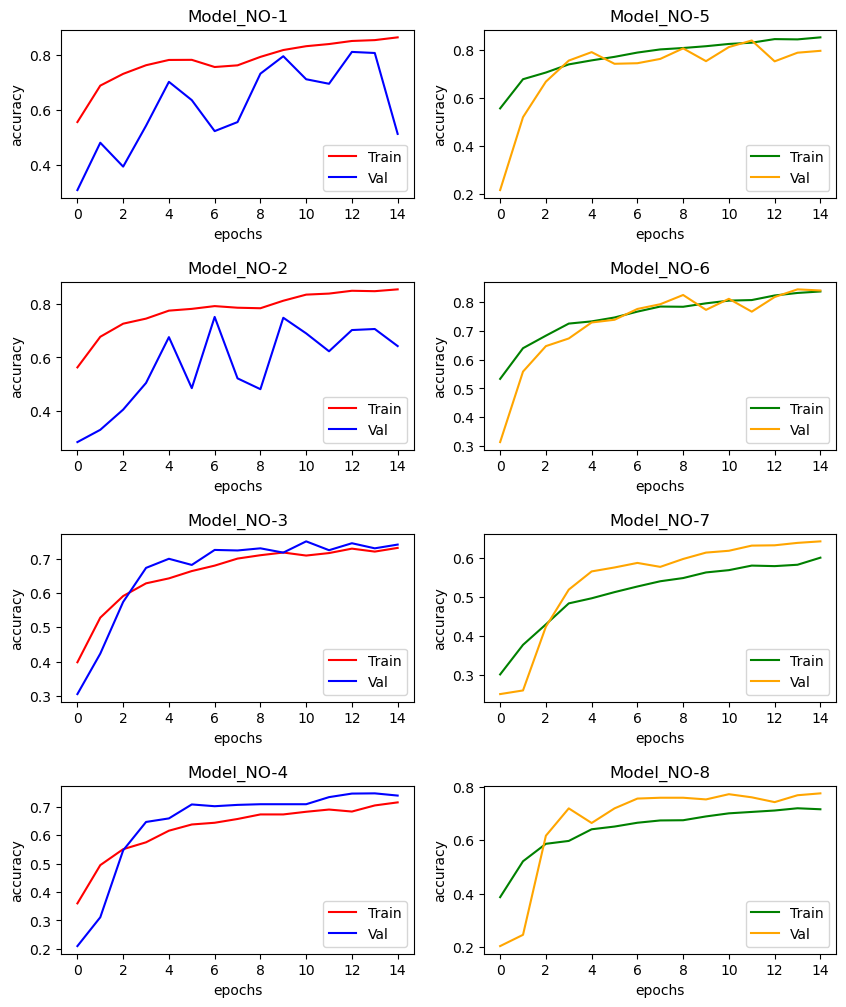

In [22]:
# initial folder
currentWorkspacePath = os.getcwd()

# Folder where histories will be saved as backup
historyFolderName = "histories"
pathToHistoriesFolder = os.path.join(currentWorkspacePath, historyFolderName)

rows = 4
columns = 2

fig, axes = plt.subplots(rows, columns, figsize = (10,12))
for index, fileName in enumerate(os.listdir(pathToHistoriesFolder)):
    history=np.load(os.path.join(pathToHistoriesFolder,fileName),allow_pickle='TRUE').item()

    if index < 4:
        rowIndex = index
        colIndex = columns - 2
        ax = axes[rowIndex, colIndex]
        ax.plot(history['accuracy'], color='red')
        ax.plot(history['val_accuracy'], color='blue')
    else:
        rowIndex = index - 4
        colIndex = columns - 1
        ax = axes[rowIndex, colIndex]
        ax.plot(history['accuracy'], color='green')
        ax.plot(history['val_accuracy'], color='orange')
    
    ax = axes[rowIndex, colIndex]

    fileName = fileName.replace('.npy', '')
    fileName = fileName.replace('history', 'Model')

    ax.set_title(fileName)
    ax.set_ylabel('accuracy')
    ax.set_xlabel('epochs')
    ax.legend(['Train', 'Val'], loc='lower right')

plt.subplots_adjust(hspace=0.5)
plt.show;


### 6.2 Displaying loss and validation loss results for all 8 models

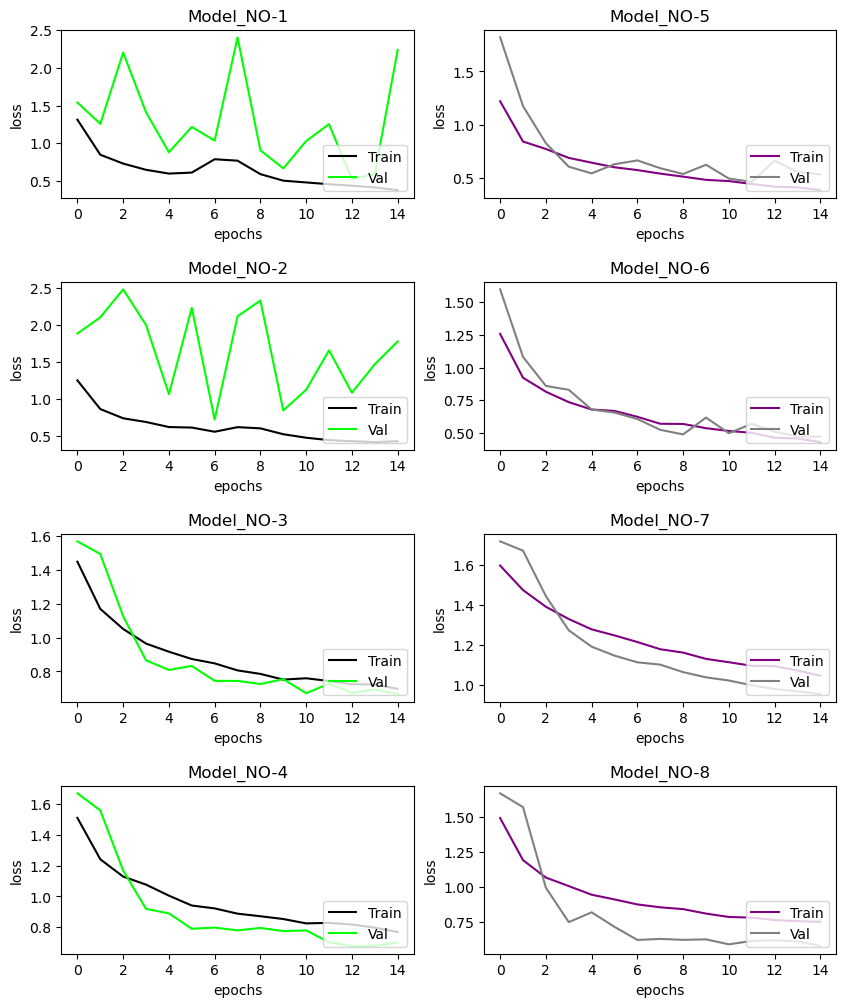

In [23]:
fig, axes = plt.subplots(rows, columns, figsize = (10,12))
for index, fileName in enumerate(os.listdir(pathToHistoriesFolder)):
    history=np.load(os.path.join(pathToHistoriesFolder,fileName),allow_pickle='TRUE').item()

    if index < 4:
        rowIndex = index
        colIndex = columns - 2
        ax = axes[rowIndex, colIndex]
        ax.plot(history['loss'], color='black')
        ax.plot(history['val_loss'], color='lime')
    else:
        rowIndex = index - 4
        colIndex = columns - 1
        ax = axes[rowIndex, colIndex]
        ax.plot(history['loss'], color='purple')
        ax.plot(history['val_loss'], color='gray')
    
    ax = axes[rowIndex, colIndex]
    fileName = fileName.replace('.npy', '')
    fileName = fileName.replace('history', 'Model')

    ax.set_title(fileName)
    ax.set_ylabel('loss')
    ax.set_xlabel('epochs')
    ax.legend(['Train', 'Val'], loc='lower right')

plt.subplots_adjust(hspace=0.5)
plt.show;

## 7. Make predictions and display results

In [24]:
import numpy as np
import tensorflow as tf

# initial folder
currentWorkspacePath = os.getcwd()

# Folder where models will be saved as backup
modelFolderName = "models"
pathToModelsFolder = os.path.join(currentWorkspacePath, modelFolderName)

# List of predictions
listOfPredictions = []

# List of predicted classes
listOfPredictedClasses = []

for index, modelName in enumerate(os.listdir(pathToModelsFolder)):
    mod = tf.keras.models.load_model(os.path.join(pathToModelsFolder, modelName))
    prediction = mod.predict(testGen)
    listOfPredictions.append(prediction)
    predicted = np.argmax(prediction, axis=1)
    listOfPredictedClasses.append(predicted)
    print(f"Model -> {modelName.replace('.keras', '')}")
    print('Predicted:', predicted)
    print('Correct:', testGen.classes)
    print()

41/41 [==============================] - 50s 1s/step
Model -> model_NO-1
Predicted: [2 0 0 ... 4 0 4]
Correct: [0 0 0 ... 4 4 4]

41/41 [==============================] - 41s 982ms/step
Model -> model_NO-2
Predicted: [0 0 1 ... 2 1 1]
Correct: [0 0 0 ... 4 4 4]

41/41 [==============================] - 42s 1s/step
Model -> model_NO-3
Predicted: [0 0 0 ... 2 4 1]
Correct: [0 0 0 ... 4 4 4]

41/41 [==============================] - 42s 995ms/step
Model -> model_NO-4
Predicted: [0 0 0 ... 4 0 1]
Correct: [0 0 0 ... 4 4 4]

41/41 [==============================] - 14s 302ms/step
Model -> model_NO-5
Predicted: [2 0 0 ... 4 4 4]
Correct: [0 0 0 ... 4 4 4]

41/41 [==============================] - 14s 294ms/step
Model -> model_NO-6
Predicted: [2 0 0 ... 4 0 4]
Correct: [0 0 0 ... 4 4 4]

41/41 [==============================] - 14s 297ms/step
Model -> model_NO-7
Predicted: [2 2 1 ... 2 0 1]
Correct: [0 0 0 ... 4 4 4]

41/41 [==============================] - 14s 300ms/step
Model -> model_NO-8

## 8. Evaluation of the models' performance

### 8.1 Performance metrics:
#### Following metrics are used:
- Accuracy_score
- Cohen_kappa_score

Model NO-1
Accuracy ->  0.5124804992199687
Cohen Kappa ->  0.39935966680484825

Model NO-2
Accuracy ->  0.6427457098283932
Cohen Kappa ->  0.5513468245017223

Model NO-3
Accuracy ->  0.7410296411856474
Cohen Kappa ->  0.6743379624316157

Model NO-4
Accuracy ->  0.7394695787831513
Cohen Kappa ->  0.6723523267692284

Model NO-5
Accuracy ->  0.7956318252730109
Cohen Kappa ->  0.7436129172118046

Model NO-6
Accuracy ->  0.8393135725429017
Cohen Kappa ->  0.7972875158026115

Model NO-7
Accuracy ->  0.6427457098283932
Cohen Kappa ->  0.5468335399182203

Model NO-8
Accuracy ->  0.7753510140405616
Cohen Kappa ->  0.716267060125415

Tuple containing maximum values: ('Model NO-6', 0.8393135725429017, 0.7972875158026115, array([2, 0, 0, ..., 4, 0, 4], dtype=int64))


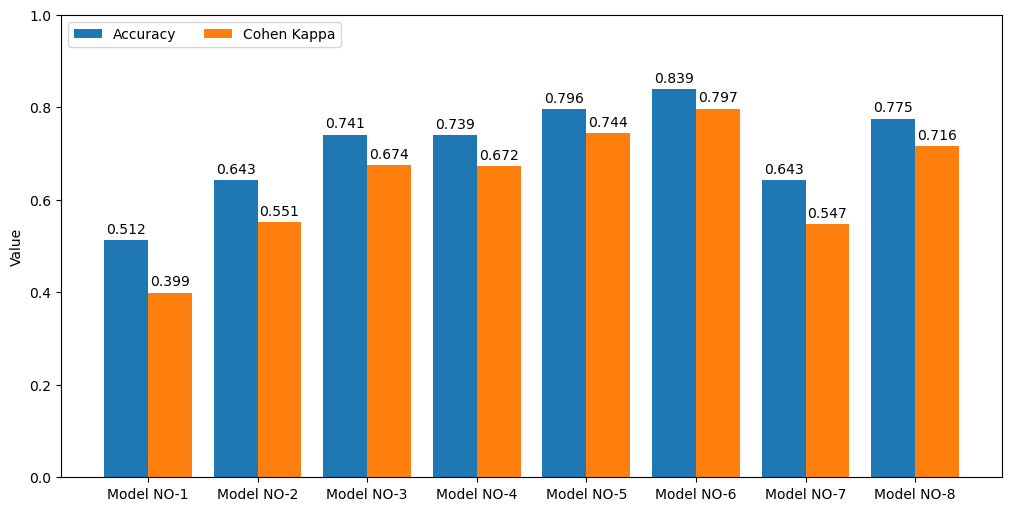

In [25]:
from sklearn.metrics import accuracy_score, cohen_kappa_score

bestModel = ()
listOfScoreTuples = []

for index, pred in enumerate(listOfPredictedClasses):
    modelNr = f"Model NO-{index+1}"
    accScore = accuracy_score(testGen.classes, pred)
    cohKapScore = cohen_kappa_score(testGen.classes, pred)

    listOfScoreTuples.append((modelNr, accScore, cohKapScore, pred))
    print(modelNr)
    print(f"Accuracy ->  {accuracy_score(testGen.classes, pred)}")
    print(f"Cohen Kappa ->  {cohen_kappa_score(testGen.classes, pred)}\n")

maxAccTuple = max(listOfScoreTuples, key=lambda t: t[1])
print("Tuple containing maximum values:", maxAccTuple)

bestModel = maxAccTuple

# Make a bar chart

# Make a tuple with just names
nameItems = [t[0] for t in listOfScoreTuples]
nameTuple = tuple(nameItems)

# Make a tuple with accuracy scores
accItems = [t[1] for t in listOfScoreTuples]
accTuple = tuple(accItems)

# Make a tuple with cohen kappa scores
cohKapItems = [t[2] for t in listOfScoreTuples]
cohKapTuple = tuple(cohKapItems)

# Make dict with data
data = {
    'Accuracy': accTuple,
    'Cohen Kappa': cohKapTuple
}

loc = np.arange(len(listOfScoreTuples))
barWidth = 0.4
counter = 0
fig, ax = plt.subplots(layout='constrained', figsize=(10,5))

for name, value in data.items():
    offset = barWidth * counter + (barWidth/2)
    bars = ax.bar(loc + offset, value, barWidth, label=name)
    ax.bar_label(bars, padding=3, fmt='%.3f')
    counter += 1

ax.set_ylabel('Value')
ax.set_title('')
ax.set_xticks(loc + barWidth, nameTuple)
ax.legend(loc='upper left', ncols=len(listOfScoreTuples))
ax.set_ylim(0, 1)

plt.show();

### 8.2 Classification report for best performing model

In [26]:
from sklearn.metrics import classification_report

print(f"Classification Report -> \n {classification_report(testGen.classes, bestModel[3])}")

Classification Report -> 
               precision    recall  f1-score   support

           0       0.86      0.83      0.85       205
           1       0.89      0.90      0.90       262
           2       0.85      0.98      0.91       321
           3       0.83      0.73      0.78       278
           4       0.74      0.71      0.72       216

    accuracy                           0.84      1282
   macro avg       0.83      0.83      0.83      1282
weighted avg       0.84      0.84      0.84      1282



### 8.3 Confusion matrix for best performing model

Confusion Matrix -> 
 [[170  14  15   1   5]
 [  4 237   5  12   4]
 [  4   1 314   2   0]
 [  4   6  21 202  45]
 [ 15   9  13  26 153]]


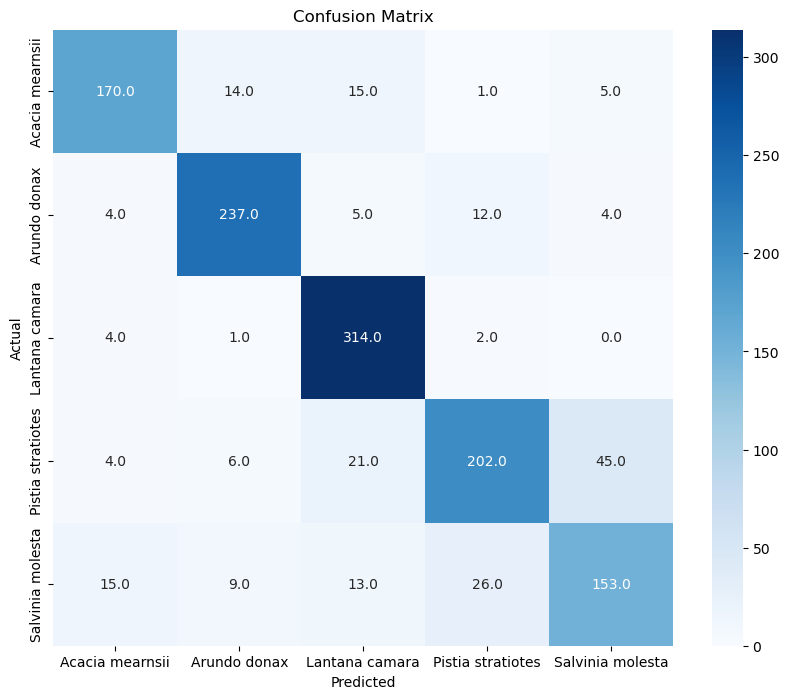

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

# Confusion matrix doesnt show values in all rows. - this is fixed by updating the seaborn library
# https://stackoverflow.com/questions/77165100/only-the-first-row-of-annotations-displayed-on-seaborn-heatmap

classNames = ["Acacia mearnsii","Arundo donax","Lantana camara","Pistia stratiotes","Salvinia molesta"]

confMatrix = confusion_matrix(testGen.classes, bestModel[3])
print(f"Confusion Matrix -> \n {confMatrix}")

confDF = pd.DataFrame(confMatrix, index=classNames, columns=classNames)

plt.figure(figsize=(10,8))
sns.heatmap(confDF, annot=True, fmt = ".1f", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()